In [1]:
from pathlib import Path
import datetime

from Bio import SeqIO
from Bio.PDB import PDBParser
from IPython.display import display
from tqdm import tqdm
from Bio.SCOP import Scop

scop = Scop(dir_path='data/scop', version='1.75')
index = SeqIO.index('data/train/astral-scopdom-seqres-gd-sel-gs-bib-40-1.75.fa', 'fasta')
result = []
for key in tqdm(index):
    try:
        for line in Path(f'data/scop_e/{key[2:4]}/{key}.ent').read_text().splitlines():
            if line.find('Source-PDB-REVDAT') > -1:
                sf = scop.getDomainBySid(key).getAscendent('sf')
                domains = sf.getDescendents('px')
                result.append((key,
                               datetime.datetime.strptime(line.split(':')[1].replace(' ', ''), '%d-%b-%y'),
                               sf.sccs,
                               len(domains)))
                break
    except FileNotFoundError:
        pass
result = sorted(result, key=lambda x: x[1], reverse=True)
result = [x for x in result if x[3] > 10]
display(result[:100])

100%|██████████| 10569/10569 [03:27<00:00, 51.04it/s]


[('d1wlqc_', datetime.datetime(2009, 2, 17, 0, 0), 'a.4.5', 762),
 ('d2vy4a1', datetime.datetime(2009, 2, 17, 0, 0), 'g.37.1', 182),
 ('d2axtu1', datetime.datetime(2009, 2, 10, 0, 0), 'a.60.12', 159),
 ('d2zqna1', datetime.datetime(2009, 2, 10, 0, 0), 'b.42.2', 119),
 ('d1y5ha3', datetime.datetime(2009, 2, 10, 0, 0), 'd.37.1', 62),
 ('d1ni9a_', datetime.datetime(2009, 2, 10, 0, 0), 'e.7.1', 151),
 ('d2axtd1', datetime.datetime(2009, 2, 10, 0, 0), 'f.26.1', 174),
 ('d2axta1', datetime.datetime(2009, 2, 10, 0, 0), 'f.26.1', 174),
 ('d2axto1', datetime.datetime(2009, 2, 10, 0, 0), 'f.4.1', 15),
 ('d3d9ta1', datetime.datetime(2009, 2, 10, 0, 0), 'g.52.1', 81),
 ('d2pqrb1', datetime.datetime(2009, 1, 27, 0, 0), 'a.118.8', 121),
 ('d1wzca1', datetime.datetime(2009, 1, 27, 0, 0), 'c.108.1', 296),
 ('d1v7ra_', datetime.datetime(2009, 1, 27, 0, 0), 'c.51.4', 44),
 ('d2dsta1', datetime.datetime(2009, 1, 27, 0, 0), 'c.69.1', 975),
 ('d1qg3a1', datetime.datetime(2009, 1, 20, 0, 0), 'b.1.2', 344),


,0
count,141422.000000
mean,0.648825
std,0.095905
min,0.500000
25%,0.572280
50%,0.635115
75%,0.712590
max,0.974390


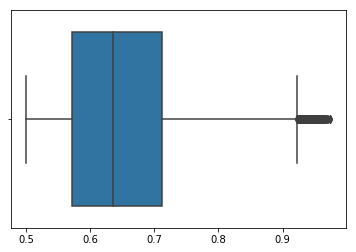

In [4]:
%matplotlib inline

from pathlib import Path
import pickle
import os
from concurrent.futures import ThreadPoolExecutor, as_completed

from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas
import seaborn
import itertools

from machina.TMtoolsCommandLine import TMalignCommandLine


# def process(c):
#     tmalign = TMalignCommandLine(f'data/scop_e/{c[0][2:4]}/{c[0]}.ent',
#                                  f'data/scop_e/{c[1][2:4]}/{c[1]}.ent')
#     tmalign.run()
#     return max(tmalign.tmscore)


# with Path(f'data/train/scop40_hie.pkl').open('rb') as f:
#     hie = pickle.load(f)
# futures = []
# with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
#     for px in tqdm(hie):
#         if len(hie[px]) < 2:
#             continue
#         futures.extend([executor.submit(process, c) for c in itertools.combinations(hie[px], 2)])
#     result = np.array([_.result() for _ in tqdm(as_completed(futures))])
# np.save('tmscore_stats.npy', result)
result = np.load('tmscore_stats.npy')
result2 = result[result >= 0.5]
result_df = pandas.DataFrame(result2)
seaborn.boxplot(result_df)
result_df.describe()

In [ ]:
from Bio import SeqIO
import numpy as np

scop40_index = SeqIO.index('data/astral-scopdom-seqres-gd-sel-gs-bib-40-1.75.fa', 'fasta')
train_ids = np.load('data/train/scop40_1fold.npy')
out = []
for t in train_ids:
    out.append(scop40_index[t])
SeqIO.write(out, 'data/blastdb/astral-scopdom-seqres-gd-sel-gs-bib-40-1.75_train_only.fasta', 'fasta')

In [ ]:
from generate_training_dataset import *
import itertools

from matplotlib import pyplot
import numpy as np
from IPython.display import display

pssm1 = parse_pssm('tests/data/pssm/1dlwa_.mtx')
pssm2 = parse_pssm('tests/data/pssm/7hbia_.mtx')
msa = parse_alignment('d1dlwa_', 'd7hbia_')

rec, win = create_dataset(pssm1, pssm2, msa, Path('/dev/null').open('w'))

pyplot.figure(figsize=(len(msa[0].seq.ungap('-'))*0.25, len(msa[1].seq.ungap('-'))*0.25))
x, y = [0], [0]
for i in range(msa.get_alignment_length()):
    pyplot.axes().add_patch(pyplot.Rectangle((x[-1]-WINDOW_CENTER, y[-1]-WINDOW_CENTER),
                                             WINDOW_WIDTH, WINDOW_WIDTH,
                                             fill=False, color='green', alpha=1.0))
    for a, b in itertools.product(range(WINDOW_WIDTH), range(WINDOW_WIDTH)):
        if rec[i][a][b] is not None:
            pyplot.axes().add_patch(
                pyplot.Circle((x[-1]-WINDOW_CENTER+a+0.5, y[-1]-WINDOW_CENTER+b+0.5),
                              radius=0.5, alpha=0.2, color='red'))
        if win[i][a][b] == 1:
            pyplot.axes().add_patch(
                pyplot.Circle((x[-1]-WINDOW_CENTER+a+0.5, y[-1]-WINDOW_CENTER+b+0.5),
                              radius=0.5, alpha=0.2, color='blue'))
    if msa[0][i] == "-":
        x.append(x[-1])
        y.append(y[-1] + 1)
    elif msa[1][i] == "-":
        x.append(x[-1] + 1)
        y.append(y[-1])
    else:
        x.append(x[-1] + 1)
        y.append(y[-1] + 1)
pyplot.yticks(np.arange(-5, len(msa[1].seq.ungap('-'))+5, 1))
pyplot.xticks(np.arange(-5, len(msa[0].seq.ungap('-'))+5, 1))
pyplot.grid(color='gray', linestyle='-')
pyplot.plot(np.array(x), np.array(y))
pyplot.show()

構造アライメントチェッカー

* 同じドメインの配列はすべて同じ長さになっていること
  * TMalignのバグなのか、まれに同じドメインIDでも長さの異なる配列が混じっている時がある
* PSSMの行数とドメイン配列の長さが一致していること

In [19]:
from pathlib import Path
import os

from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from tqdm import tqdm_notebook as tqdm
from Bio.Blast.Applications import NcbipsiblastCommandline
from tqdm import tqdm_notebook

from machina.generate_training_dataset import parse_pssm


results = []
seq_index = SeqIO.index('data/train/scop40_structural_alignment.fasta', 'fasta')
for record_id in tqdm(seq_index):
    l = record_id.split('&')
    results.append(l[0])
    results.append(l[1])
for domain in tqdm(set(results)):
    # Check length
    try:
        MultipleSeqAlignment([SeqRecord(seq_index[_].seq.ungap('-'), id=_) for _ in seq_index if _.startswith(f'{domain}&')])
    except:
        print(domain)
for domain in tqdm(set(results)):
    r = seq_index[[_ for _ in seq_index if _.startswith(f'{domain}&')][0]]
    len1 = len(r.seq.ungap('-'))
    len2 = len(parse_pssm(f'data/pssm/{domain[2:4]}/{domain}.mtx').pssm)
    if len1 != len2:
        print(domain)
        SeqIO.write(SeqRecord(r.seq.ungap('-'), id=domain), f'{domain}.fasta', 'fasta')
        NcbipsiblastCommandline(query=f'{domain}.fasta', db='/data/DB/blastdb/uniref90', num_threads=int(os.cpu_count()),
                                num_iterations=3, out_ascii_pssm=f'data/pssm/{domain[2:4]}/{domain}.mtx',
                                save_pssm_after_last_round=True)()
        Path(f'{domain}.fasta').unlink()


In [ ]:
import os

from machina.generate_training_dataset import create_scop40_dataset


create_scop40_dataset(5, 0.5, os.cpu_count() - 1)

In [ ]:
from machina.conv_training_csv2npy import csv2npy_parted, csv2npy


csv2npy(200, 'data/train/scop40_logscore_tmscore50_w5')  # Needs > 40GB RAM

# csv2npy(360, 'data/train/scop40_tmscore50_w9')  # Needs > 200GB RAM
# csv2npy_parted(360, 'data/train/scop40_tmscore50_w9')
# csv2npy_parted(360, 'data/train/scop40_tmscore50_w9', n_part=3, n_sample=396540456)

In [2]:
import numpy as np

from machina.reduce_training_dataset import random_sampling, negative_down_sampling


# negative_down_sampling('data/train/scop40_tmscore50_w9', 3)

ratio = 0.01
print(ratio)
random_sampling('data/train/scop40_logscore_tmscore50_w5', ratio)
X = np.load(f'data/train/scop40_logscore_tmscore50_w5_randomsampling_ratio{ratio}_x.npy')
print(X.shape)
Y = np.load(f'data/train/scop40_logscore_tmscore50_w5_randomsampling_ratio{ratio}_y.npy')
print(Y.shape)
print(np.argwhere(Y == 1).shape)
print(np.argwhere(Y == 0).shape)

ratio = 0.1
print(ratio)
random_sampling('data/train/scop40_logscore_tmscore50_w5', ratio)
X = np.load(f'data/train/scop40_logscore_tmscore50_w5_randomsampling_ratio{ratio}_x.npy')
print(X.shape)
Y = np.load(f'data/train/scop40_logscore_tmscore50_w5_randomsampling_ratio{ratio}_y.npy')
print(Y.shape)
print(np.argwhere(Y == 1).shape)
print(np.argwhere(Y == 0).shape)

0.01
(2150375, 200)
(2150375,)
(176007, 1)
(1974368, 1)
0.1
(21503756, 200)
(21503756,)
(1763022, 1)
(19740734, 1)


In [3]:
from pathlib import Path
import pickle

from tqdm import tqdm_notebook as tqdm
from Bio.SCOP import Scop
from Bio import SeqIO
import numpy as np

from machina.generate_training_dataset import get_validation_data


db_index = SeqIO.index('data/train/scop40_structural_alignment.fasta', 'fasta')
scop_root = Scop(dir_path=Path('data/scop'), version='1.75')
test_data = np.load('data/test/scop40.npy')
with Path('data/train/scop40_hie.pkl').open('rb') as f:
    hie = pickle.load(f)

for t in tqdm(test_data):
    Path(f'data/test/{t}').mkdir(exist_ok=True)
    query_sf_sunid = scop_root.getDomainBySid(t).getAscendent('sf').sunid
    for d in hie[query_sf_sunid]:
        x, y = get_validation_data(t, d, db_index, 5, 0)
        np.save(f'data/test/{t}/{d}_x.npy', x)
        np.save(f'data/test/{t}/{d}_y.npy', y)

# Check shapes
for t in tqdm(test_data):
    query_sf_sunid = scop_root.getDomainBySid(t).getAscendent('sf').sunid
    for d in hie[query_sf_sunid]:
        x = np.load(f'data/test/{t}/{d}_x.npy')
        y = np.load(f'data/test/{t}/{d}_y.npy')
        assert x.shape[0] == y.shape[0] * y.shape[1]
